# Parameter Mapping Sonification using mesonic

Let's see how we can use the Synth concept for Parameter Mapping Sonification (PMson) and use the Playback filtering feature to explore our PMson.

It is recommended to use headphones for the examples as they use panning.

In [1]:
import mesonic

## Preparation of Synths

Let's start by preparing our Context and Synths.

In [2]:
context = mesonic.create_context()

<IPython.core.display.Javascript object>

Starting sclang process... Done.
Registering OSC /return callback in sclang... Done.
Loading default sc3nb SynthDefs... Done.
Booting SuperCollider Server... Done.


Let's create two Synths

- A discrete (s1) immutable Synth named s1i
- and a continuous (s2) mutable Synth named s2

In [3]:
s1i = context.synths.create("s1", mutable=False)
s2 = context.synths.create("s2", track=1)

## Data Preparation

We also prepare the data for the sonification.

We will use the [Palmer penguins dataset](https://allisonhorst.github.io/palmerpenguins/) for the examples.

In [4]:
import seaborn as sns

In [5]:
df = sns.load_dataset("penguins")
df = df.dropna(subset=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"])
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


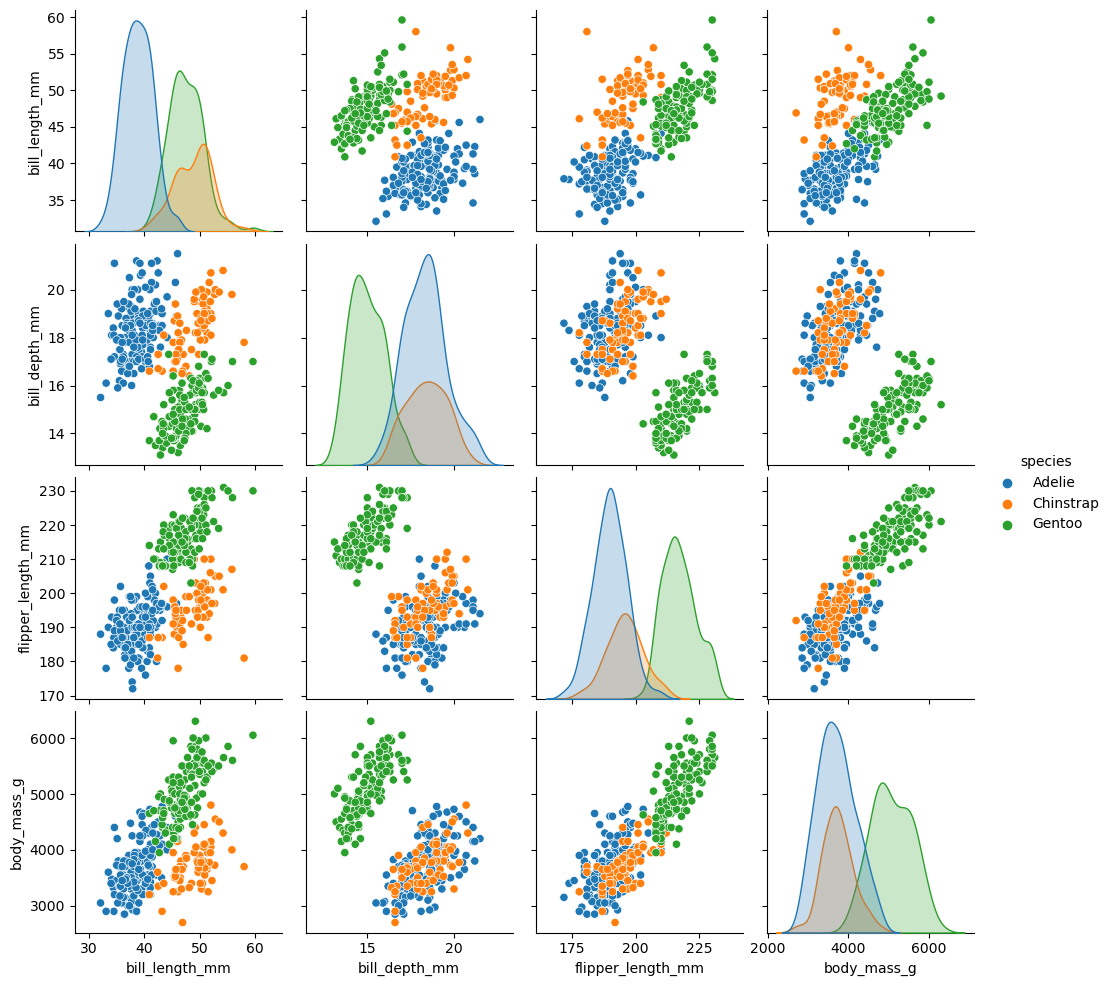

In [6]:
sns.pairplot(data=df, hue="species");

## Mapping Preparation

We use the mapping functions from pyamapping

In [7]:
from pyamapping import linlin, midi_to_cps

And we also define a small helper class that allows us to map the values linearly

In [8]:
class DFMapper:
    # We define a mapping helper class that gets a dataframe
    # and allows to provide a index and column of a value in the dataframe
    # to map the corresponding value from the source (smin,smax)
    # to the target (tmin,tmax) linearly.
    # If the source range is None we get the min / max of the column
    
    def __init__(self, df):
        self.df = df
        
    def linear(self, idx, col, tmin, tmax, smin=None, smax=None):
        if smin is None:
            smin = getattr(self.df, col).min()
        if smax is None:
            smax = getattr(self.df, col).max()
        # get the value using the idx and column name
        value = getattr(self.df, col)[idx]
        return linlin(value, smin, smax, tmin, tmax)

Create a instance for later usage

In [9]:
m = DFMapper(df)

## Example of a discrete PMSon

For a discrete PMSon a immutable Synth is often very practical as we do not need to worry about

* overlapping Synth playbacks and
* the Synth is expected to end itself.

Let's create the PMSon

In [10]:
context.clear()

# we iterate over the penguins dataset
for idx in df.index:
    # longer flipper -> later onset
    onset = m.linear(idx, "flipper_length_mm", 0, 5)
    # use the context manager to provide time and add the species as info.
    with context.at(onset, info={"species": df.loc[idx, "species"]}):
        s1i.start(
            # heavier -> lower frequency
            freq = midi_to_cps(m.linear(idx, "body_mass_g", 96, 50)),        
            # longer bill -> longer sound
            dur = m.linear(idx, "bill_length_mm", 0, 0.3),
            # pan the sounds according to sex
            pan = {"Female": 1, "Male": -1}.get(df.loc[idx, "sex"], 0),  
            amp = 0.15
        )

dpmson = context.timeline.to_dict()  # we can save the times with the Events as dict and insert them later again

Timeline(0.0-6.0 (6.0) #entries=55)

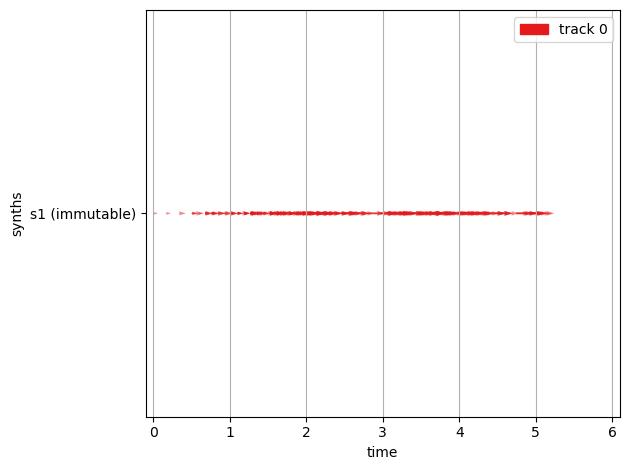

In [11]:
context.timeline.plot()
context.timeline

In [12]:
context.playback.start()

## Example of a continuous PMSon

For a continuous PMSon a mutable Synths is the obvious choice.

* The Synth can be changed by setting the Parameters or using `Synth.set` and
* it allows stopping the Synth playback in a controlled way and thus allows using continuous (not self ending) Synths 

In [13]:
context.clear()

# the continuous Synth must be started at the beginning
with context.at(0):
    s2.start()


# we use a similiar mapping here but set the Parameters
# of the continuous Synth instead of starting the Synth.
for idx in df.index:
    onset = m.linear(idx, "flipper_length_mm", 0, 5)
    with context.at(onset, info={"species": df.loc[idx, "species"]}) as tp:
        s2.freq = midi_to_cps(m.linear(idx, "body_mass_g", 96, 50))
        s2.amp = m.linear(idx, "bill_length_mm", 0, 0.2)
        s2.pan = {"Female": 1, "Male": -1}.get(df.loc[idx, "sex"], 0)


# and also don't forget to stop the continuous Synth
with context.at(context.timeline.last_timestamp + 0.1):
    s2.stop()

cpmson = context.timeline.to_dict()

Timeline(0-6.1 (6.1) #entries=56)

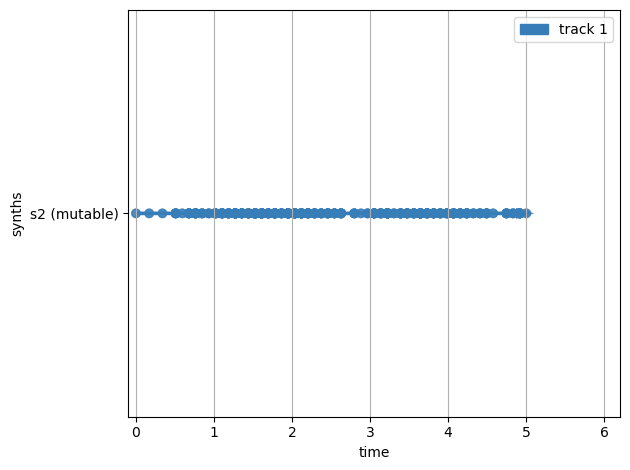

In [14]:
context.timeline.plot()
context.timeline

In [15]:
context.playback.start()

## Example of a mixed PMSon

To mix the both PMSon types we can simply combine the two code snippets from above.

In [16]:
context.clear()
# Here we simply extend the timeline with the stored Timelines.
context.timeline.extend(dpmson)
context.timeline.extend(cpmson)

The Timeline is now updated accordingly. 

Timeline(0.0-6.1 (6.1) #entries=56)

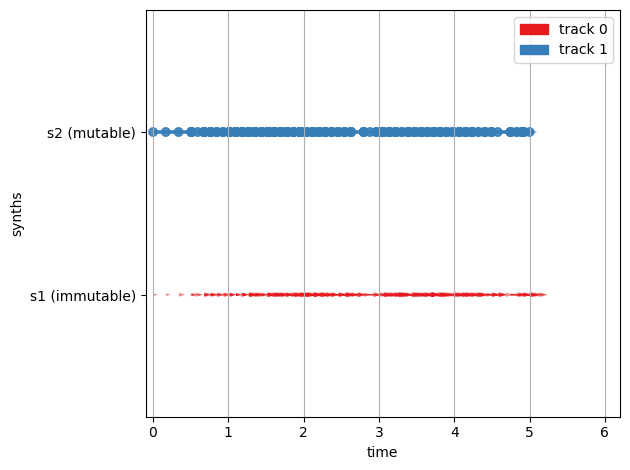

In [17]:
context.timeline.plot()
context.timeline

Note that only one more entry now exists as we use the same onset as in the discrete mapping.

We can now hear both Synths playing.

In [18]:
context.playback.start()

* Using the processor we can select the single tracks.
* We used the tracks here to divide the different PMSon types.
* so if we select just one track we can listen to the different PMSon types separately

In [19]:
context.processor.selected_tracks = [1]

In [20]:
context.playback.start()

You can adjust this while the Playback is running.

In [21]:
context.processor.selected_tracks = [0, 1]

However this can quickly lead to inconsistencies in the timeline

* a continuous Synths might not be stopped or started which will then result in errors in the backend. 

In [22]:
context.processor.selected_tracks = [0]

A `Context.stop` will stop all Playbacks created by the Context aswell as trigger `Backend.stop` of the backend that is used. This should stop all Events from being executed and also stop all sounds that have become stuck in the backend.

In [23]:
context.stop()  

## Filtering and Transforming the Sonification

The Playback can be filtered by tracks as shown above.

Another way to filter the Playback is to add a `event_filter` to BundleProcessor.

Let's do it with the discrete PMSon

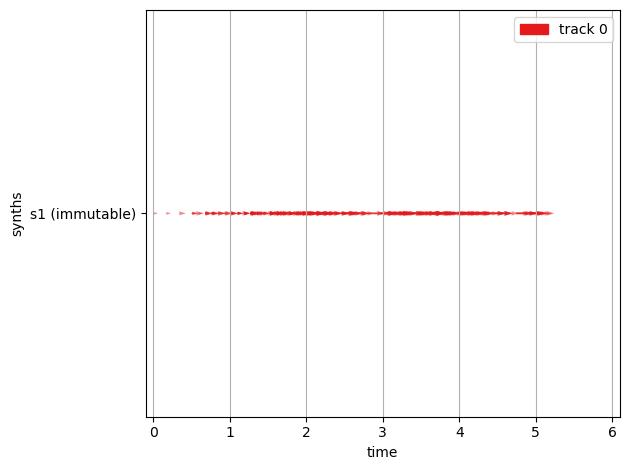

In [24]:
context.clear()
context.timeline.extend(dpmson)
context.timeline.plot()

We can filter f.e by species

In [25]:
df.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [26]:
def create_filter(selected_species):
    def filter_fun(event):
        if event.info.get("species", None) == selected_species:
            return event
        else:
            return None
    return filter_fun

This allows us to listen just to the single species.

In [27]:
filter_adelie = create_filter("Adelie")
context.processor.event_filters.append(filter_adelie)

In [28]:
context.playback.start()

The filter can be removed using the following code

In [29]:
context.processor.event_filters.remove(filter_adelie)

Let's try filtering the Chinstrap penguins

In [30]:
filter_chinstrap = create_filter("Chinstrap")
context.processor.event_filters.append(filter_chinstrap)

In [31]:
context.playback.start()

In [32]:
context.playback.processor.event_filters.remove(filter_chinstrap)

The Gentoo penguins are the ones with the greatest body mass and the longest flippers. Therefore they will only sound quite late in the timeline.

In [33]:
filter_gentoo = create_filter("Gentoo")
context.processor.event_filters.append(filter_gentoo)

In [34]:
context.playback.start()

All filters can be removed by resetting the filter list

In [35]:
context.processor.event_filters = []

It is also possible to use the a filter to transform the Events.

Here we create a slider that allows us to change the panning of the events during Playback.

In [36]:
import ipywidgets as widgets

In [37]:
pan_slider = widgets.FloatSlider(value=0, min=-1, max=1)

In [38]:
pan_slider

FloatSlider(value=0.0, max=1.0, min=-1.0)

In [39]:
pan_slider.value

1.0

In [40]:
def transform_pan(event):
    # start events
    if event.data.get("pan", None) != None:
        event.data["pan"] = pan_slider.value
    # set events
    if event.data.get("name", None) == "pan":
        print("changed set")
        event.data["new_value"] = pan_slider.value
    return event

context.processor.event_filters = []
context.processor.event_filters.append(transform_pan)

In [41]:
context.playback.start()

In [42]:
# set the Event processing back to normal.
context.playback.processor.event_filters = []   

In [43]:
context.close()

Quitting SCServer... Done.
Exiting sclang... Done.
